# THEORY OF APPROXIMATE REACTION NETWORKS

In [1]:
import numpy as np
import pandas as pd
import tellurium as te
import controlSBML as ctl
import control
import matplotlib.pyplot as plt

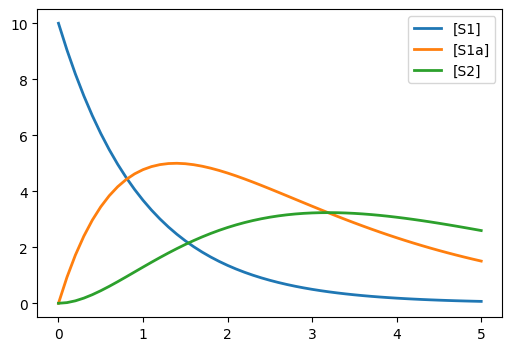

In [2]:
model = """
model *main()
S1 -> S1a; k*S1
S1a -> S2; k2*S1a
S2 -> ; k3*S2

S1 = 10
S1a = 0
S2 = 0
k = 1
k2 = 0.5
k3 = 0.5
end
"""
rr = te.loada(model)
rr.simulate()
rr.plot()

In [3]:
ctl.__version__

'1.1.01'

# Theory

Notation
* $\alpha(s), \beta(s)$ are polynomials in $1/s$
* $D(s)$ is the denominator of transfer function
* $G(s)$ is the transfer function from $S_1$ to $S_M$
* $j$ indexes reactions
* $J_p = |p|$ is the number of reactions in the spath $p$
* $\bar{J} = max_{p \in P} J_p$
* $k_{m_1 m_2}$ is the kinetic constant for the reaction $S_{m_1} \rightarrow S_{m_2}$
* $m$ indexes species
* $M$ is the number of species
* $N(s)$ is the numerator of transfer function
* $p$ indexes spaths
* $P$ is the set of sequential paths from $S_1$ to $S_M$
* $s$ is the Laplace variable
* $S$ are chemical species

Consider a uni-uni, mass action reaction network. That is, all reactions have a single reactant and a single product.

The species are $S_m (s)$, $1 \leq m \leq M$. Reaction $S_i \rightarrow S_j$ has kinetics $k_{ij} S_i$. We assume that there is at most one reaction from $S_i$ to $S_j$, which is not a limitation since if there are multiple, their kinetic constants can be added to produce a single reaction. We want to construct $G(s)$, the transfer function with $S_1$ as input and $S_M$ as output.

A **forward sequential path (fpath)** $p$ from $S_1$ to $S_M$ is a sequence of $J$ reactions such that:
  1. There is a single reaction $S_1 \rightarrow S_{m_1}$.
  1. There is a single reaction $S_{m_{J}} \rightarrow S_M$.
  1. For every product $S_{m_j}$, except for $S_M$, there is a single reaction $S_{m_{j-1}} \rightarrow S_{m_j}$.
Note that if there are loops a path may be of infinite length.

A **backward sequential path (bpath)** $p$ from $S_M$ to $S_m$ is a sequence of $J$ reactions such that:
  1. There is a single reaction $S_M \rightarrow S_{m_1}$.
  1. For every product $S_{m_j}$, there is a single reaction $S_{m_{j-1}} \rightarrow S_{m_j}$, except for $S_{J_p}$ if $J_p$ is finite.

There are two types of bpath. In a **bpath I**, $J_p < \infty$ and there is a single reaction $S_{m_j} \rightarrow S_M$. In a **bpath II**, $S_M$ never appears as a product. Note that because of loops, $|P_I|$ may be infinite.

A **sequencial path (spath)** is either a fpath or a bpath.

We want to find an expression for $\dot{S}_M$ in terms of $S_1$.
Note that
\begin{eqnarray}
\dot{S}_M
& \equiv & s S(s)_M \\
& = & \sum_m^M (k_{mM} - k_{Mm}) S_{m}(s) \\
& = & \alpha(s) S_1 (s) - \beta(s) S_M(s)
\end{eqnarray}
where $\alpha(s), \beta(s)$ are polynomials in $\frac{1}{s}$. Note that the transfer function from $S_1$ to $S_M$ is
\begin{eqnarray}
G(s) &=& \frac{N(s)}{D(s)} \\
& = & \frac{s^{\bar{J}}\alpha(s)}{s^{\bar{J}} (s + \beta(s))}
\end{eqnarray}
where $\bar{J} = max_{p \in P} J_p$ for $P$ the set of spaths starting at $S_1$ or $S_M$ and the length of spath $p$ is $J_p$. Note that the order of the numerator is always smaller than the denominator and so we will obtain a proper (feasible) transfer function.

If there are loops in the reaction network, then $\bar{J}$ is infinite. This has two implications. First, there are constraints on the kinetic constants to ensure stability. Second, we may need to choose a maximum value for $\bar{J}$ to calculate it in practice. We return to this later.

For now, we assume that $\bar{J}$ is finite, and focus on $\alpha(s)$ and $\beta(s)$. $\alpha(s)$ relates to the synthesis of $S_M$ from $S_1$. Note that some synthesis may be the result of spaths.

First consider the reaction $S_1 \rightarrow S_M$ with kinetic constant $k_{1M}$. Thus, $\alpha(s)$ has a term $k_{1M} s^0 = k_{1M}$.
Now consider the spath of length 2.
\begin{eqnarray}
S_1 & \rightarrow & S_m \\
S_m & \rightarrow & S_M . \\
\end{eqnarray}
This spath implies that $\frac{d S_M}{d t}$ increases with $k_{mM} S_{mM}$ and $\frac{d S_m}{d t}$ increases with $k_{1m} S_1$. So, $\frac{k_{mM}k_{1m}}{s}$ is a term in $\alpha(s)$. Generalizing, for an spath $p$ with $|p|$ reactions from $S_1$ to $S_M$, there is a term $\frac{\prod_j k_{j_l j_r}}{s^J}$, where $j_l$ indexex the reactant species and $j_r$ indexes the product species. Summing across each spath $p$ in $P$, the spaths from $S_1$ to $S_M$
\begin{eqnarray}
\alpha(s) = \sum_{p \in P} \frac{\prod_{j \in p} k_{j_l j_r}}{s^{J_p}}
\end{eqnarray}
where $J_p = |P|$. Note that this sum can be infinite.

Now consider $\beta(s)$. In all cases we remove $S_M$ at a rate specified by the first reaction in the bpath. However, we may additionally add $S_M$ for a bpath type I.
\begin{eqnarray}
\beta(s)  =
&
\sum_{p \in P_I }
 \frac{\prod_{j \in p} k_{j_l j_r}}{s^{J_p}}
- \sum_{m} \frac{k_{M, m}}{s} \\
 \\
\end{eqnarray}
Note that $s^{\bar{J}} (s - \beta(s))$ is the characteristic equation of this system. So if the first summation of $\beta(s)$ is non-zero, the system is unstable by Routh-Hurwitz since there will be coefficients of $s^n$ with both positive and negative signs.

Notes
1. The characteristic equation has one nonzero pole and $\bar{J} -1$ poles at zero.
1. The solution has the form $\sum_{n=0}^{\bar{J}} c_n t^n e^{-pt}$, where $p$ is the pole. How well can this approximate an arbitrary function?

# Composition Approach

The idea is to develop transfer functions based on an algebra on reaction networks.
**Outline**
1. Consider the network
  * $S_1 \rightarrow S_2$ at rate $k_{1,2}S_1$
  * $S_2 \rightarrow ∅$ at rate $k_2 S_2$
1. The foregoing has the transfer function $\frac{k_2}{s + k_{1,2}}$.
1. Creating a sequential path of networks multiplies their transfer functions. The result is a composite system that has all the poles and zeroes of the component systems.
1. Summing the outputs (two paths to equivalent chemical species) adds transfer functions. The result is a composite system that has the poles of the component systems but different zeroes.
1. Feedback transforms the poles of a transfer function.

**Claim**. Given a proper transfer function whose numerator and denominator are polynomials with real coefficients, we can construct a reaction network with the given transfer function.

**Implications**
1. Can design oscillators.
1. Can approximate reaction networks.
1. Have an understanding of poles and zeros.

# Definitions

## Key concepts

* A (uni-uni) **reaction** is a triple expressed as $S_I \xrightarrow{k_{IO}} S_O$ indicates the transformation of mass from species $S_I$ to $S_O$ using mass action with the kinetic constant $k_{IO}$.

* A **reaction network** is $N = <S, S_I, S_O, R, k_I, k_O>$ where:
    * $S$ is a set of chemical species
    * $S_I, S_O \in S$ are input and output species.
    * $R$ is a set of reactions.
    * $k_I S_I$ is the rate at which the input is consumed.
    * $k_O S_O$ is the rate at which the output is degraded.

* We indicate components of an object using a dot ("."), such as $N.S_I$


## Network Operations

These are operations applied to SISO reaction networks that produce a new SISO reaction network.


**Serial (binary)**.
Let $N_1, N_2$ be SISO reaction networks such that $N_1.S \bigcap N_2.S = \{N_1.S_O = S_2.S_I \}$. Serial applied to these networks, $N = N_1 \circ  N_2$ is defined as: $N.I =N_1.S_I$, $N.O = N_2.S_O$, $R = R_1 \bigcup R_2$, $S = N_1.S \bigcup N_2.S$.

**Parallel (binary)**.
Let $N_1, N_2$ be a SISO reaction networks such that $N_1.S \bigcap N_2.S = \{N_1.S_I = N_2.S_I \}$. Parallel applied to these networks produces $N = N_1 + N_2 =<S_I, S_O, R, S>$ where:
* $S_I = N_1.S_I = N_2.S_I$
* $S_O = N_1.S_O + N_2.S_O$
* $R = R_1 \bigcup R_2$
* $S = S_1 \bigcup S_2 \bigcup \{ O \}$

**Scale (unary)**.
Let $N$ be a SISO reaction network and $K$ be a positive real number. $K \times N$ is $<S, S_O^{\star}, S_I, R>$ such that $S_O^{\star}$ has concentration $K S_O$.

**Feedback (unary)**



**Specify $K_I, k_O$ for each network operation.**

## Networks

**Two Species Basic Network (2SBN).**
A 2SBN for $S_1, S_2$ is:
* $R = \{ S_I \xrightarrow{k_{IO}} S_O, S_O \xrightarrow{k_O} ∅ \}$
* $S = \{S_I, S_O\}$
* $k_I = k_{IO}$
* $k_O = k_{O}$

Claim that the transfer function from $S_I$ to $S_O$ is $\frac{k_{IO}}{s + k_O}$.

### Serial 2SBN

Let $N^A$, $N^B$ be 2SBN with $S^A_O = S^B_O$.
Then $N = N^A \circ N^B$ has the following properties:
* $S = \{S^A_I, S^A_O = S^B_I, S^B_O \}$
* $R = R^A \bigcup R^B$
* $S_I = S^A_I$
* $S_O = S^B_O$
* $k_I = k^A_I$
* $k_O = k^B_O$
$N$
has transfer function $H(s)$
$$H(s) = H^A(s) H^B(s)\frac{s + k^A_O}{s+ k^B_I + k^A_O}$$.

# Claims

1. **Transfer function for concatenation**. Let $N_1, N_2$ be reaction networks with transfer functions $H_1(s), H_2(s)$ that satisfy the conditions for concatenation. Let $N = N_1 \circ N_2$, and let $H(s)$ be its transfer function. Claim that $H(s) = H_1 (s) H_2(s)$.
1. **Transfer function for branching**. Let $N_1, N_2$ be reaction networks with transfer functions $H_1(s), H_2(s)$ that satisfy the conditions for branching. Let $H(s)$ be the transfer function for $N_1 + N_2$. Claim that $H(s) = H_1 (s) + H_2(s)$.
1. **Transfer function for scaling**. Let $N_1$ be a reaction network with transfer function $H_1(s)$. Let $N  = K \times N_1$, and $H(s)$ be its transfer function. Claim that $H(s) = KH_1(s)$.

# Numerical Studies

## Basic Network

In [4]:
model1 = """
model *main()
$S1 -> S2; k12*S1
S2 ->; k2*S2
S1 =5
k12 = 2
k2 = 1
end
"""

model2 = """
model *main()
$S1 -> S2; k12*S1
S2 ->; k2*S2
S2 -> S3; k23*S2
S3 ->; k3*S3
S1 =5
k12 = 2
k2 = 1
k23 = 3
k3 = 2
end
"""

model3 = """
model *main()
$S2 -> S3; k23*S2
S3 ->; k3*S3
S2 =5
k23 = 3
k3 = 2
end
"""

In [5]:
def plotStep(model=model1, **kwargs):
    rr = te.loada(model)
    for key, value in kwargs.items():
        rr[key] = value
    rr.simulate()
    rr.plot()

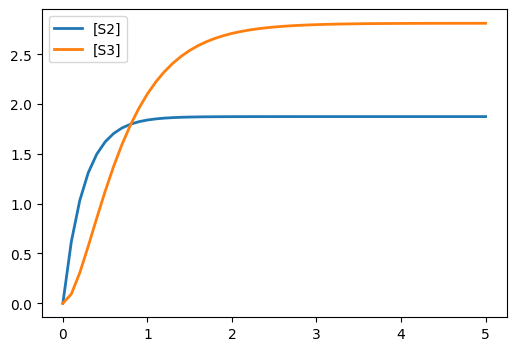

In [6]:
plotStep(model=model2, S1=5, k12=1.5, k2=1)

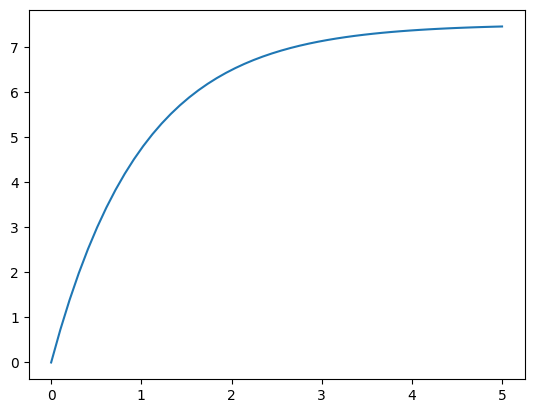

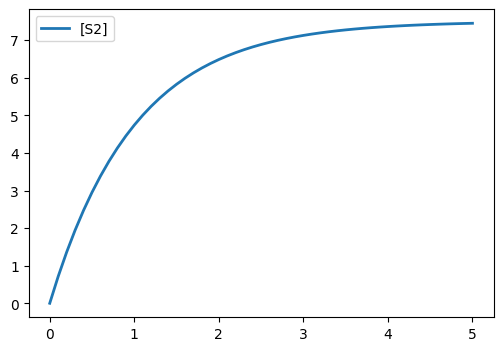

In [7]:
k12 = 1.5
k2 = 1
S1 = 5
tf = control.TransferFunction([k12], [1, k2])
tv, yv = control.step_response(tf, np.linspace(0, 5, 50))
plt.plot(tv, S1*yv)
plotStep(model=model1, S1=S1, k12=k12, k2=k2)

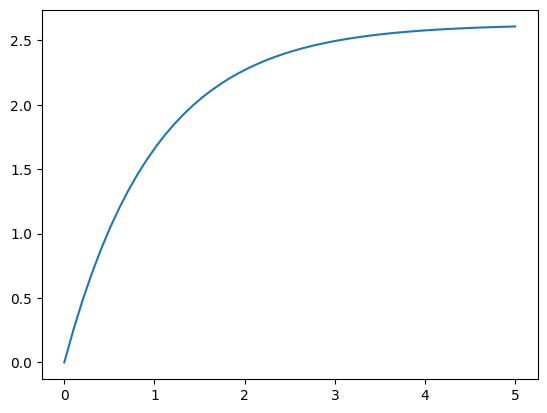

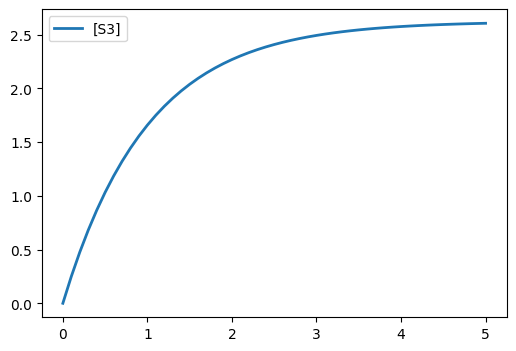

In [8]:
k23 = 1.5
k3 = 1
S2 = 1.75
tf = control.TransferFunction([k23], [1, k3])
tv, yv = control.step_response(tf, np.linspace(0, 5, 50))
plt.plot(tv, S2*yv)
plotStep(model=model3, S2=S2, k23=k23, k3=k3)

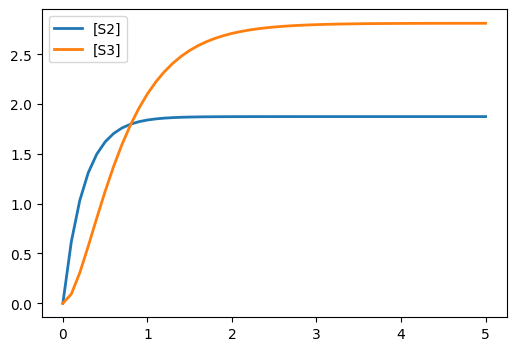

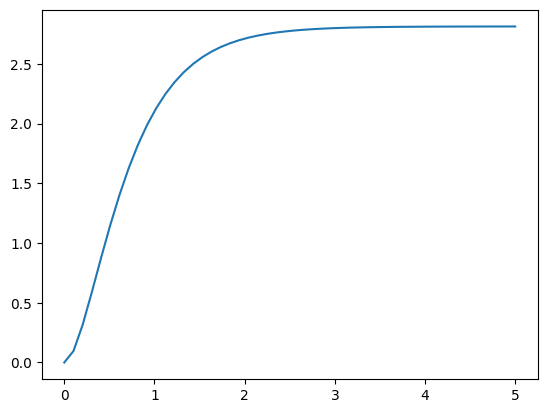

In [9]:
k12 = 1.5
k2 = 1
k23 = 3
k3 = 2
S1 = 5
tf1 = control.TransferFunction([k12], [1, k2])
tf2 = control.TransferFunction([k23], [1, k3])
tf3 = control.TransferFunction([1, k2], [1, k2+k23 ])
# tf3 adjusts for the consumption of S2 by the second network
tf = tf1*tf2*tf3
tv, yv = control.step_response(tf, np.linspace(0, 5, 50))
plotStep(model=model2, S1=S1, k12=k12, k2=k2, k23=k23, k3=k3)
plt.plot(tv, S1*yv)

In [10]:
tf2.dcgain()

1.5

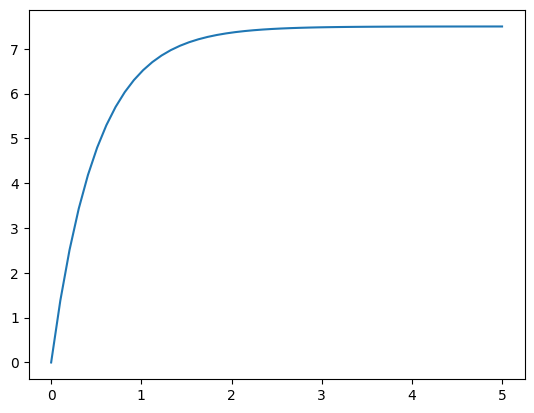

In [11]:
tf1 = control.TransferFunction([k12], [1, k2])
tv, yv = control.step_response(tf2, np.linspace(0, 5, 50))
plt.plot(tv, 5*yv)

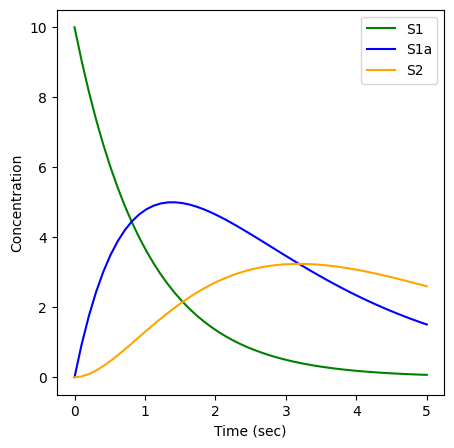

In [12]:
ctlsb = ctl.ControlSBML(model, input_names=["S1"], output_names=["S2"])
_ = ctlsb.plotModel(markers=["", "", ""])

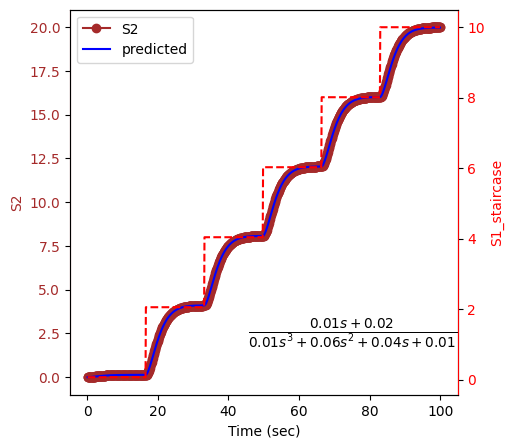

In [13]:
_ = ctlsb.plotTransferFunctionFit(num_numerator=2, num_denominator=4, times=np.linspace(0, 100, 1000))

100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


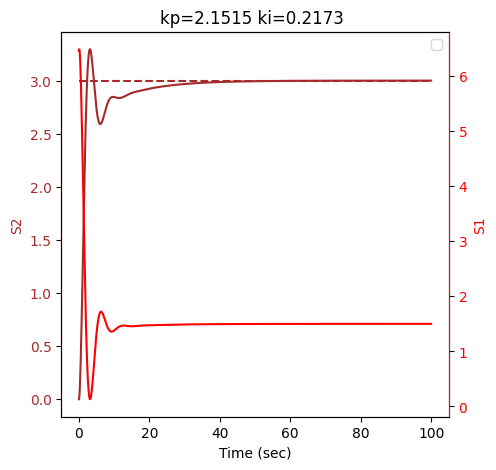

In [14]:
_ = ctlsb.plotDesign(kp_spec=True, setpoint=3, ki_spec=True, times=np.linspace(0, 100, 1000))